In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [100]:
from pyspark.sql.functions import mean as _mean, stddev as _stddev, col
from pyspark.sql.types import DateType, StringType
from pyspark.sql import SparkSession
import pyspark.sql.functions as F
from pyspark_dist_explore import hist

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [6]:
spark = SparkSession.builder.appName('test').getOrCreate()

In [7]:
spark

In [36]:
taxi = spark.read.csv('financial-data/2020_Yellow_Taxi_Trip_Data__January_-_June_.csv',
                      header = True, inferSchema = True)

In [37]:
taxi.show(10, False)

+--------+----------------------+----------------------+---------------+-------------+----------+------------------+------------+------------+------------+-----------+-----+-------+----------+------------+---------------------+------------+--------------------+
|VendorID|tpep_pickup_datetime  |tpep_dropoff_datetime |passenger_count|trip_distance|RatecodeID|store_and_fwd_flag|PULocationID|DOLocationID|payment_type|fare_amount|extra|mta_tax|tip_amount|tolls_amount|improvement_surcharge|total_amount|congestion_surcharge|
+--------+----------------------+----------------------+---------------+-------------+----------+------------------+------------+------------+------------+-----------+-----+-------+----------+------------+---------------------+------------+--------------------+
|1       |01/01/2020 12:28:15 AM|01/01/2020 12:33:03 AM|1              |1.2          |1         |N                 |238         |239         |1           |6.0        |3.0  |0.5    |1.47      |0.0         |0.3      

In [40]:
taxi = taxi.withColumn('tpep_pickup_datetime', F.split(F.col('tpep_pickup_datetime'), ' ').getItem(0))
taxi = taxi.withColumn('tpep_dropoff_datetime', F.split(F.col('tpep_dropoff_datetime'), ' ').getItem(0))

In [44]:
taxi = taxi.withColumn('tpep_pickup_datetime', F.to_date(F.col('tpep_pickup_datetime'), 'MM/dd/yyyy'))
taxi = taxi.withColumn('tpep_dropoff_datetime', F.to_date(F.col('tpep_dropoff_datetime'), 'MM/dd/yyyy'))

In [45]:
taxi.show(2)

+--------+--------------------+---------------------+---------------+-------------+----------+------------------+------------+------------+------------+-----------+-----+-------+----------+------------+---------------------+------------+--------------------+
|VendorID|tpep_pickup_datetime|tpep_dropoff_datetime|passenger_count|trip_distance|RatecodeID|store_and_fwd_flag|PULocationID|DOLocationID|payment_type|fare_amount|extra|mta_tax|tip_amount|tolls_amount|improvement_surcharge|total_amount|congestion_surcharge|
+--------+--------------------+---------------------+---------------+-------------+----------+------------------+------------+------------+------------+-----------+-----+-------+----------+------------+---------------------+------------+--------------------+
|       1|          2020-01-01|           2020-01-01|              1|          1.2|         1|                 N|         238|         239|           1|        6.0|  3.0|    0.5|      1.47|         0.0|                  0.3

In [76]:
df_stats = taxi.select(
    _mean(col('trip_distance')).alias('mean'),
    _stddev(col('trip_distance')).alias('std')
).collect()

mean = df_stats[0]['mean']
std = df_stats[0]['std']

taxi = taxi.filter(F.col('trip_distance') > mean - 3*std).filter(F.col('trip_distance') < mean + 3*std)

In [78]:
df_stats = taxi.select(
    _mean(col('fare_amount')).alias('mean'),
    _stddev(col('fare_amount')).alias('std')
).collect()

mean = df_stats[0]['mean']
std = df_stats[0]['std']

taxi = taxi.filter(F.col('fare_amount') > mean - 3*std).filter(F.col('fare_amount') < mean + 3*std)

In [81]:
df_stats = taxi.select(
    _mean(col('tolls_amount')).alias('mean'),
    _stddev(col('tolls_amount')).alias('std')
).collect()

mean = df_stats[0]['mean']
std = df_stats[0]['std']

taxi = taxi.filter(F.col('tolls_amount') > mean - 3*std).filter(F.col('tolls_amount') < mean + 3*std)

In [84]:
covid_cutoff = '2020-03-07'
taxi_before_lockdown = taxi.filter(F.col('tpep_pickup_datetime') < covid_cutoff)
taxi_after_lockdown = taxi.join(taxi_before_lockdown, taxi.tpep_pickup_datetime == taxi_before_lockdown.tpep_pickup_datetime, 'leftanti')

In [85]:
taxi_before_lockdown.cache()
taxi_after_lockdown.cache()
taxi_before_lockdown.show(2)

+--------+--------------------+---------------------+---------------+-------------+----------+------------------+------------+------------+------------+-----------+-----+-------+----------+------------+---------------------+------------+--------------------+
|VendorID|tpep_pickup_datetime|tpep_dropoff_datetime|passenger_count|trip_distance|RatecodeID|store_and_fwd_flag|PULocationID|DOLocationID|payment_type|fare_amount|extra|mta_tax|tip_amount|tolls_amount|improvement_surcharge|total_amount|congestion_surcharge|
+--------+--------------------+---------------------+---------------+-------------+----------+------------------+------------+------------+------------+-----------+-----+-------+----------+------------+---------------------+------------+--------------------+
|       1|          2020-01-01|           2020-01-01|              1|          1.2|         1|                 N|         238|         239|           1|        6.0|  3.0|    0.5|      1.47|         0.0|                  0.3

In [86]:
# dropped 264407 from before
taxi_before_lockdown = taxi_before_lockdown.filter(F.col('passenger_count') > 0)
taxi_after_lockdown = taxi_after_lockdown.filter(F.col('passenger_count') > 0)

In [87]:
taxi_before_lockdown.groupBy().avg().select(F.col('avg(passenger_count)').alias('avg_passenger_count'), F.col('avg(trip_distance)').alias('avg_trip_distance'), F.col('avg(fare_amount)').alias('avg_fare_amount'), F.col('avg(tolls_amount)').alias('avg_tolls_amount'),
                                           F.col('avg(total_amount)').alias('avg_total_amount')).show()

+-------------------+------------------+------------------+--------------------+------------------+
|avg_passenger_count| avg_trip_distance|   avg_fare_amount|    avg_tolls_amount|  avg_total_amount|
+-------------------+------------------+------------------+--------------------+------------------+
|  1.534777428879881|2.3067274396525685|11.002172041137074|0.002206872256476069|16.404412946856556|
+-------------------+------------------+------------------+--------------------+------------------+



In [88]:
taxi_after_lockdown.groupBy().avg().select(F.col('avg(passenger_count)').alias('avg_passenger_count'), F.col('avg(trip_distance)').alias('avg_trip_distance'), F.col('avg(fare_amount)').alias('avg_fare_amount'), F.col('avg(tolls_amount)').alias('avg_tolls_amount'),
                                           F.col('avg(total_amount)').alias('avg_total_amount')).show()

+-------------------+-----------------+------------------+--------------------+------------------+
|avg_passenger_count|avg_trip_distance|   avg_fare_amount|    avg_tolls_amount|  avg_total_amount|
+-------------------+-----------------+------------------+--------------------+------------------+
| 1.4330409551832726|2.461323592656568|10.781830462285697|0.002684621196303...|16.241029504157225|
+-------------------+-----------------+------------------+--------------------+------------------+



(array([9.534550e+06, 0.000000e+00, 1.939091e+06, 0.000000e+00,
        0.000000e+00, 5.120020e+05, 0.000000e+00, 2.469290e+05,
        0.000000e+00, 0.000000e+00, 4.667240e+05, 0.000000e+00,
        2.731950e+05, 0.000000e+00, 0.000000e+00, 5.300000e+01,
        0.000000e+00, 2.800000e+01, 0.000000e+00, 2.300000e+01]),
 array([1. , 1.4, 1.8, 2.2, 2.6, 3. , 3.4, 3.8, 4.2, 4.6, 5. , 5.4, 5.8,
        6.2, 6.6, 7. , 7.4, 7.8, 8.2, 8.6, 9. ]),
 <a list of 20 Patch objects>)

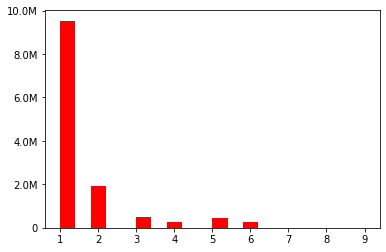

In [89]:
fig, ax = plt.subplots()
hist(ax, 
     taxi_before_lockdown.select('passenger_count'), 
     bins = 20, color=['red'])


(array([1.825521e+06, 0.000000e+00, 2.840540e+05, 0.000000e+00,
        0.000000e+00, 7.291800e+04, 0.000000e+00, 3.031100e+04,
        0.000000e+00, 0.000000e+00, 6.544500e+04, 0.000000e+00,
        4.464200e+04, 0.000000e+00, 0.000000e+00, 4.000000e+00,
        0.000000e+00, 4.000000e+00, 0.000000e+00, 6.000000e+00]),
 array([1. , 1.4, 1.8, 2.2, 2.6, 3. , 3.4, 3.8, 4.2, 4.6, 5. , 5.4, 5.8,
        6.2, 6.6, 7. , 7.4, 7.8, 8.2, 8.6, 9. ]),
 <a list of 20 Patch objects>)

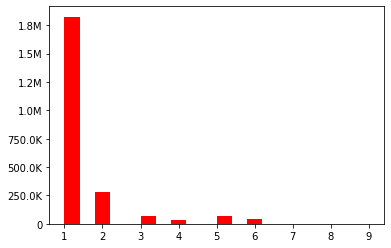

In [90]:
# higher tendency to take trips alone
fig, ax = plt.subplots()
hist(ax, 
     taxi_after_lockdown.select('passenger_count'), 
     bins = 20, color=['red'])



(array([7.036491e+06, 3.684101e+06, 1.044004e+06, 4.821720e+05,
        2.473090e+05, 1.290730e+05, 8.136100e+04, 5.480200e+04,
        3.628200e+04, 3.679000e+04, 3.519700e+04, 2.976500e+04,
        1.414300e+04, 4.698000e+03, 2.405000e+03, 2.819000e+03,
        2.155000e+03, 7.150000e+02, 4.950000e+02, 2.750000e+02,
        1.970000e+02, 1.550000e+02, 1.040000e+02, 1.080000e+02,
        1.010000e+02, 5.700000e+01, 4.500000e+01, 4.900000e+01,
        3.700000e+01, 3.700000e+01]),
 array([ 0.        ,  1.66466667,  3.32933333,  4.994     ,  6.65866667,
         8.32333333,  9.988     , 11.65266667, 13.31733333, 14.982     ,
        16.64666667, 18.31133333, 19.976     , 21.64066667, 23.30533333,
        24.97      , 26.63466667, 28.29933333, 29.964     , 31.62866667,
        33.29333333, 34.958     , 36.62266667, 38.28733333, 39.952     ,
        41.61666667, 43.28133333, 44.946     , 46.61066667, 48.27533333,
        49.94      ]),
 <a list of 30 Patch objects>)

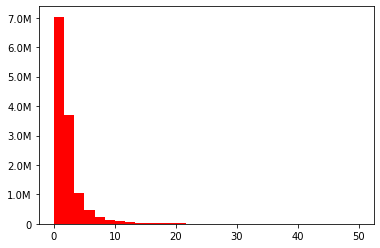

In [98]:

fig, ax = plt.subplots()
hist(ax, 
     taxi_before_lockdown.select('trip_distance'), 
     bins = 30, color=['red'])



(array([1.17269e+06, 6.77116e+05, 2.17110e+05, 1.00858e+05, 5.33250e+04,
        2.80370e+04, 1.87370e+04, 1.27520e+04, 7.62400e+03, 6.47300e+03,
        5.90300e+03, 4.66200e+03, 2.24500e+03, 1.00000e+03, 5.42000e+02,
        5.18000e+02, 3.41000e+02, 1.70000e+02, 9.50000e+01, 8.50000e+01,
        7.50000e+01, 6.30000e+01, 4.00000e+01, 3.90000e+01, 4.50000e+01,
        2.20000e+01, 1.70000e+01, 1.70000e+01, 1.80000e+01, 1.80000e+01]),
 array([ 0.        ,  1.66466667,  3.32933333,  4.994     ,  6.65866667,
         8.32333333,  9.988     , 11.65266667, 13.31733333, 14.982     ,
        16.64666667, 18.31133333, 19.976     , 21.64066667, 23.30533333,
        24.97      , 26.63466667, 28.29933333, 29.964     , 31.62866667,
        33.29333333, 34.958     , 36.62266667, 38.28733333, 39.952     ,
        41.61666667, 43.28133333, 44.946     , 46.61066667, 48.27533333,
        49.94      ]),
 <a list of 30 Patch objects>)

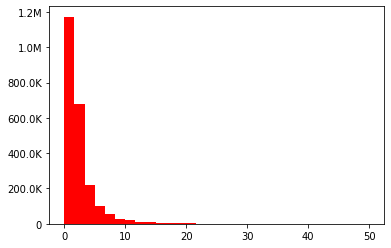

In [99]:
# most trips are much shorter after the lockdown
fig, ax = plt.subplots()
hist(ax, 
     taxi_after_lockdown.select('trip_distance'), 
     bins = 30, color=['red'])

(array([2.133624e+06, 8.105661e+06, 1.881713e+06, 4.574190e+05,
        1.408700e+05, 8.433300e+04, 6.942900e+04, 3.051100e+04,
        1.175100e+04, 3.396000e+03, 1.813000e+03, 1.057000e+03,
        9.130000e+02, 6.380000e+02, 5.400000e+02, 4.810000e+02,
        3.420000e+02, 2.760000e+02, 2.670000e+02, 1.820000e+02,
        2.380000e+02, 1.010000e+02, 1.230000e+02, 8.100000e+01,
        9.400000e+01, 8.200000e+01, 4.200000e+01, 5.600000e+01,
        5.300000e+01, 3.100000e+01]),
 array([1.00000e-02, 1.00030e+01, 1.99960e+01, 2.99890e+01, 3.99820e+01,
        4.99750e+01, 5.99680e+01, 6.99610e+01, 7.99540e+01, 8.99470e+01,
        9.99400e+01, 1.09933e+02, 1.19926e+02, 1.29919e+02, 1.39912e+02,
        1.49905e+02, 1.59898e+02, 1.69891e+02, 1.79884e+02, 1.89877e+02,
        1.99870e+02, 2.09863e+02, 2.19856e+02, 2.29849e+02, 2.39842e+02,
        2.49835e+02, 2.59828e+02, 2.69821e+02, 2.79814e+02, 2.89807e+02,
        2.99800e+02]),
 <a list of 30 Patch objects>)

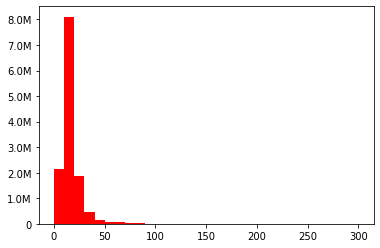

In [96]:
fig, ax = plt.subplots()
hist(ax, 
     taxi_before_lockdown.select('total_amount'), 
     bins = 30, color=['red'])

(array([4.672010e+05, 1.386443e+06, 3.026180e+05, 8.955800e+04,
        3.063600e+04, 1.576600e+04, 1.055500e+04, 4.446000e+03,
        1.490000e+03, 5.480000e+02, 3.490000e+02, 2.090000e+02,
        1.840000e+02, 1.140000e+02, 8.900000e+01, 9.500000e+01,
        6.100000e+01, 6.300000e+01, 4.200000e+01, 3.100000e+01,
        4.700000e+01, 2.800000e+01, 1.700000e+01, 1.800000e+01,
        2.200000e+01, 2.100000e+01, 9.000000e+00, 1.000000e+01,
        4.000000e+00, 1.100000e+01]),
 array([1.00000e-02, 9.90700e+00, 1.98040e+01, 2.97010e+01, 3.95980e+01,
        4.94950e+01, 5.93920e+01, 6.92890e+01, 7.91860e+01, 8.90830e+01,
        9.89800e+01, 1.08877e+02, 1.18774e+02, 1.28671e+02, 1.38568e+02,
        1.48465e+02, 1.58362e+02, 1.68259e+02, 1.78156e+02, 1.88053e+02,
        1.97950e+02, 2.07847e+02, 2.17744e+02, 2.27641e+02, 2.37538e+02,
        2.47435e+02, 2.57332e+02, 2.67229e+02, 2.77126e+02, 2.87023e+02,
        2.96920e+02]),
 <a list of 30 Patch objects>)

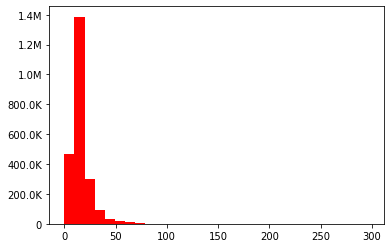

In [97]:
fig, ax = plt.subplots()
hist(ax, 
     taxi_after_lockdown.select('total_amount'), 
     bins = 30, color=['red'])

In [107]:
taxi_before_lockdown.count()

12925942

In [111]:
taxi_before_lockdown_pd = taxi_before_lockdown.select('total_amount', 'trip_distance', 'passenger_count').sample(False, 0.05, seed=0).toPandas()

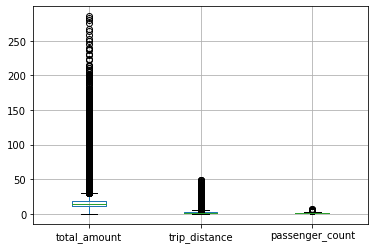

In [112]:
taxi_before_lockdown_pd.boxplot()

In [113]:
taxi_after_lockdown_pd = taxi_after_lockdown.select('total_amount', 'trip_distance', 'passenger_count').sample(False, 0.1, seed=0).toPandas()

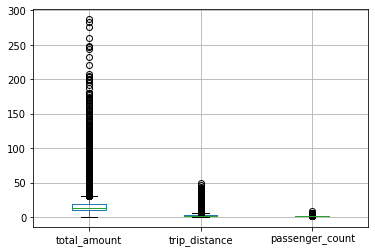

In [114]:
taxi_after_lockdown_pd.boxplot()